In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
import time
import warnings
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay, precision_recall_fscore_support
)
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

folderPath = '/content/drive/MyDrive/animalShelterDatasets'
allFiles = glob.glob(os.path.join(folderPath, '*.csv'))

# Load and concatenate all CSV files
dfList = []
for fileName in allFiles:
    try:
        df = pd.read_csv(fileName, index_col=None, header=0)
    except UnicodeDecodeError:
        df = pd.read_csv(fileName, encoding='latin-1')
    dfList.append(df)

df = pd.concat(dfList, axis=0, ignore_index=True)

Mounted at /content/drive


In [ ]:
# Data Cleaning

# Dropping unnecessary columns
columnsToDelete = ['AnimalID', 'Crossing', 'Jurisdiction', 'LastUpdate']
df = df.drop(columns=columnsToDelete)

# Checking for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*80 + "\n")
print("Missing Values (%):")
print((df.isnull().sum()/len(df))*100)

# Display intake and outcome type distributions
print("\nIntake Types:")
print(df['IntakeType'].value_counts())
print("="*80)
print("\nOutcome Types:")
print(df['OutcomeType'].value_counts())

# Remove records not eligible for adoption (Animal shelter also functions as Animal Control)
dfCleaned = df[df['IntakeType'] != 'DISPO REQ'].copy()
dfCleaned = dfCleaned[dfCleaned['IntakeCondition'] != 'DEAD'].copy()
dfCleaned = dfCleaned[dfCleaned['IntakeType'] != 'WILDLIFE'].copy()

# Create binary adoption field which will be our target variable
adopted = ['ADOPTION']
dfCleaned['Adopted'] = dfCleaned['OutcomeType'].apply(
    lambda x: 1 if x in adopted else 0
)

# Convert date columns to datetime
dfCleaned['IntakeDate'] = pd.to_datetime(dfCleaned['IntakeDate'])
dfCleaned['OutcomeDate'] = pd.to_datetime(dfCleaned['OutcomeDate'])
dfCleaned['LengthOfStay'] = (
    dfCleaned['OutcomeDate'] - dfCleaned['IntakeDate']
).dt.days
dfCleaned['DOB'] = pd.to_datetime(dfCleaned['DOB'])


Missing Values:
AnimalName           78103
AnimalType               0
PrimaryColor             1
SecondaryColor       80860
PrimaryBreed             0
Sex                      0
DOB                  68432
Age                      0
IntakeDate               0
IntakeCondition          0
IntakeType               0
IntakeSubtype        10154
IntakeReason        129285
OutcomeDate            859
OutcomeType            860
OutcomeSubtype      136463
OutcomeCondition      8523
dtype: int64


Missing Values (%):
AnimalName           57.233829
AnimalType            0.000000
PrimaryColor          0.000733
SecondaryColor       59.254157
PrimaryBreed          0.000000
Sex                   0.000000
DOB                  50.146926
Age                   0.000000
IntakeDate            0.000000
IntakeCondition       0.000000
IntakeType            0.000000
IntakeSubtype         7.440845
IntakeReason         94.739966
OutcomeDate           0.629475
OutcomeType           0.630207
OutcomeSubtype      100.0

In [ ]:
# Creating our dataset that only includes dogs
dfDogs = dfCleaned[dfCleaned['AnimalType']=='DOG'].copy()

# Group rare breeds into 'OTHER BREED' category
topBreeds = dfDogs['PrimaryBreed'].value_counts().nlargest(15).index
dfDogs.loc[:, 'PrimaryBreed'] = dfDogs['PrimaryBreed'].where(
    dfDogs['PrimaryBreed'].isin(topBreeds), 'OTHER BREED'
)

# Group rare colors into 'OTHER' category
topColors = dfDogs['PrimaryColor'].value_counts().nlargest(10).index
dfDogs.loc[:, 'PrimaryColor'] = dfDogs['PrimaryColor'].where(
    dfDogs['PrimaryColor'].isin(topColors), 'OTHER'
)

top2ndColors = dfDogs['SecondaryColor'].value_counts().nlargest(10).index
dfDogs.loc[:, 'SecondaryColor'] = dfDogs['SecondaryColor'].where(
    dfDogs['SecondaryColor'].isin(top2ndColors), 'OTHER'
)

In [ ]:
def parseAge(ageStr):
    """
    Original dataset had age formatted as:
    "2 YEARS 6 MONTHS", "3 WEEKS", "10 DAYS"
    This function helps parse the strings into years (float data type)
    """
    if pd.isna(ageStr):
        return np.nan

    ageStr = str(ageStr).strip().upper()

    # Handle invalid entries
    if ageStr in ['NO AGE', 'INCORRECT AGE', 'UNKNOWN', 'N/A', '', 'NONE']:
        return np.nan

    # If already a number, return it
    try:
        return float(ageStr)
    except ValueError:
        pass

    # Year + Months ("2 YEARS 6 MONTHS" or "2 YRS 6 MOS")
    matchYm = re.search(
        r'(\d+)\s*(?:YEARS?|YRS?)\s*(\d+)\s*(?:MONTHS?|MOS?)', ageStr
    )
    if matchYm:
        years = float(matchYm.group(1))
        months = float(matchYm.group(2))
        return years + months / 12

    # Years only
    matchYears = re.search(r'(\d+)\s*(?:YEARS?|YRS?)', ageStr)
    if matchYears:
        return float(matchYears.group(1))

    # Months only
    matchMonths = re.search(r'(\d+)\s*(?:MONTHS?|MOS?)', ageStr)
    if matchMonths:
        return float(matchMonths.group(1)) / 12

    # Weeks only
    matchWeeks = re.search(r'(\d+)\s*(?:WEEKS?|WKS?)', ageStr)
    if matchWeeks:
        return float(matchWeeks.group(1)) / 52

    # Days only
    matchDays = re.search(r'(\d+)\s*(?:DAYS?|DYS?)', ageStr)
    if matchDays:
        return float(matchDays.group(1)) / 365

    # If none matched, return NaN
    print(f"Could not parse: '{ageStr}'")
    return np.nan


In [ ]:
dfDogs['Age'] = dfDogs['Age'].apply(parseAge)
print(f"\nAfter parsing - NaN count: {dfDogs['Age'].isna().sum()}")
print(f"After parsing - Valid count: {dfDogs['Age'].notna().sum()}")


After parsing - NaN count: 5552
After parsing - Valid count: 24847


In [ ]:
# Converting age and length of stay fields to numeric
dfDogs['Age'] = pd.to_numeric(dfDogs['Age'], errors='coerce')
dfDogs['LengthOfStay'] = pd.to_numeric(dfDogs['LengthOfStay'], errors='coerce')
dfDogs['Age'] = dfDogs['Age'].fillna(dfDogs['Age'].median())
dfDogs['LengthOfStay'] = dfDogs['LengthOfStay'].fillna(
    dfDogs['LengthOfStay'].median()
)

In [ ]:
# Feature engineering

# Create binary feature: Has Name
dfCleaned['HasName'] = dfCleaned['AnimalName'].apply(
    lambda x: 1 if pd.notna(x) else 0
)
dfDogs['HasName'] = dfDogs['AnimalName'].apply(lambda x: 1 if pd.notna(x) else 0)

# Create season feature based on intake month
def getSeason(month):
    """Convert month number to season name"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

dfDogs['Season'] = dfDogs['IntakeDate'].dt.month.apply(getSeason)


In [ ]:
# One-hot encoding
categoricalCols = [
    'AnimalType', 'PrimaryBreed', 'Sex', 'IntakeCondition',
    'IntakeType', 'PrimaryColor', 'SecondaryColor', 'Season'
]
dfDogs.columns = dfDogs.columns.str.strip()
dfDogs = pd.get_dummies(
    dfDogs, columns=categoricalCols, drop_first=True
)


Dog Adoption Distribution:
Adopted
0    20997
1     9402
Name: count, dtype: int64


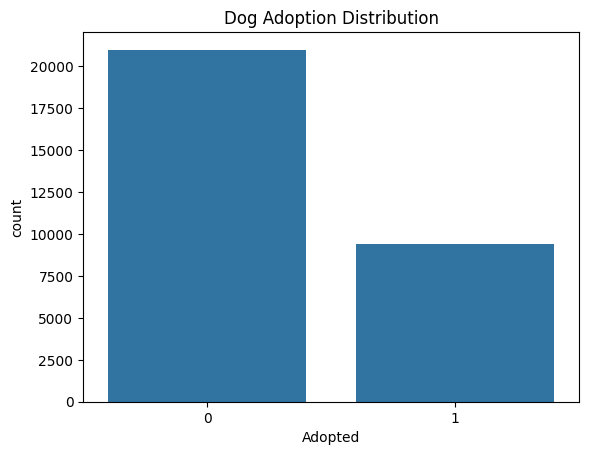


Adoption Rate: 0.309
Non-Adoption Rate: 0.691


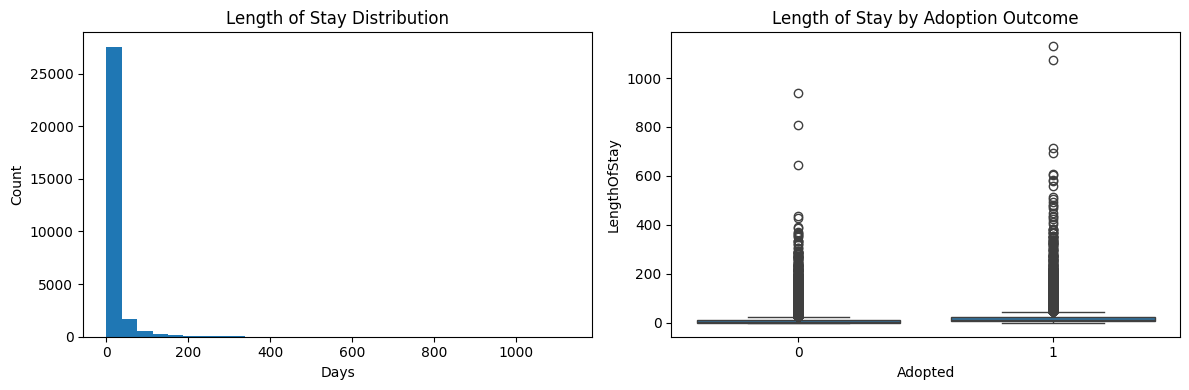


Mean Length of Stay by Adoption:
Adopted
0    12.057008
1    24.314933
Name: LengthOfStay, dtype: float64


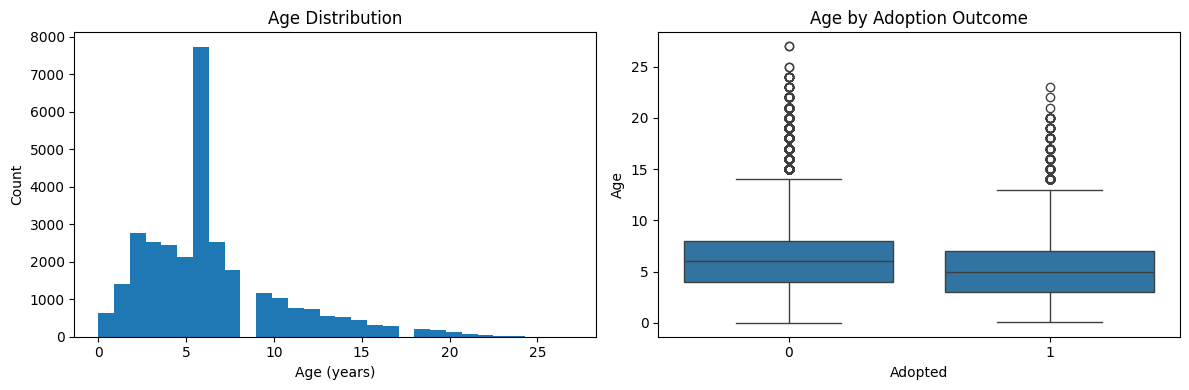


Mean Age by Adoption:
Adopted
0    6.828880
1    5.568135
Name: Age, dtype: float64

Breed Adoption Rates:
             breed  adoptionRate  count
0    BORDER COLLIE      0.387309    457
5    GERM SHEPHERD      0.382429   2709
3        DACHSHUND      0.376847    406
9         PIT BULL      0.342141   4390
13  SIBERIAN HUSKY      0.329870   1925
8      OTHER BREED      0.315713   9005
6    LABRADOR RETR      0.315189   1139
4   FRENCH BULLDOG      0.306159    552
2     CHIHUAHUA SH      0.281268   5237
1     CHIHUAHUA LH      0.266979    854
7          MALTESE      0.237237    999
11      POODLE MIN      0.228108    925
14  YORKSHIRE TERR      0.182674    531
12        SHIH TZU      0.176596    470
10      POMERANIAN      0.135266    414

Adoption Rate by Intake Type:
IntakeType_RETURN        0.711754
IntakeType_FOSTER        0.685237
IntakeType_OWNER SUR     0.390834
IntakeType_TRANSFER      0.332781
IntakeType_STRAY         0.272249
IntakeType_EUTH REQ      0.235977
IntakeType_S/N CL

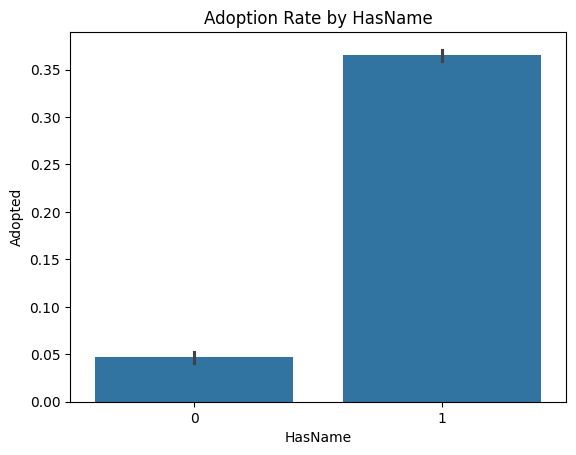


Adoption Rate by HasName:
HasName
0    0.047092
1    0.365033
Name: Adopted, dtype: float64


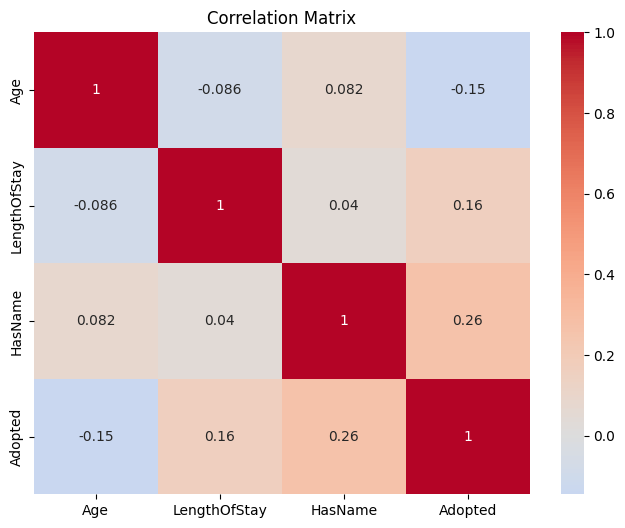

In [ ]:
# EDA

# Adoption distribution for dogs
print("\nDog Adoption Distribution:")
print(dfDogs['Adopted'].value_counts())
sns.countplot(x='Adopted', data=dfDogs)
plt.title('Dog Adoption Distribution')
plt.show()

adoptionRate = dfDogs['Adopted'].mean()
nonAdoptionRate = 1 - adoptionRate
print(f"\nAdoption Rate: {adoptionRate:.3f}")
print(f"Non-Adoption Rate: {nonAdoptionRate:.3f}")

# How long do dogs stay at the shelter?
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(dfDogs['LengthOfStay'], bins=30)
plt.title('Length of Stay Distribution')
plt.xlabel('Days')
plt.ylabel('Count')

# By adoption
plt.subplot(1, 2, 2)
sns.boxplot(x='Adopted', y='LengthOfStay', data=dfDogs)
plt.title('Length of Stay by Adoption Outcome')
plt.tight_layout()
plt.show()
print("\nMean Length of Stay by Adoption:")
print(dfDogs.groupby('Adopted')['LengthOfStay'].mean())

# Age of dogs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(dfDogs['Age'], bins=30)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(x='Adopted', y='Age', data=dfDogs)
plt.title('Age by Adoption Outcome')
plt.tight_layout()
plt.show()

print("\nMean Age by Adoption:")
print(dfDogs.groupby('Adopted')['Age'].mean())


# Breed adoption distribution
breedCols = [c for c in dfDogs.columns if c.startswith('PrimaryBreed_')]
breedStats = []

for c in breedCols:
    subset = dfDogs.loc[dfDogs[c] == 1, 'Adopted']
    if subset.shape[0] > 0:
        breedStats.append({
            'breed': c.replace('PrimaryBreed_', ''),
            'adoptionRate': subset.mean(),
            'count': subset.shape[0]
        })

breedStats = pd.DataFrame(breedStats).sort_values(
    'adoptionRate', ascending=False
)
print("\nBreed Adoption Rates:")
print(breedStats)

# What intake types lead to adoptions?
intakeCols = [c for c in dfDogs.columns if c.startswith('IntakeType_')]
intakeAdoption = {}

for col in intakeCols:
    adoptionRate = dfDogs[dfDogs[col] == True]['Adopted'].mean()
    intakeAdoption[col] = adoptionRate

print("\nAdoption Rate by Intake Type:")
print(pd.Series(intakeAdoption).sort_values(ascending=False))

# Pets that have names analysis
sns.barplot(x='HasName', y='Adopted', data=dfDogs)
plt.title('Adoption Rate by HasName')
plt.show()

print("\nAdoption Rate by HasName:")
print(dfDogs.groupby('HasName')['Adopted'].mean())

# Correlation analysis
numericCols = ['Age', 'LengthOfStay', 'HasName']
corr = dfDogs[numericCols + ['Adopted']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()



In [ ]:
dfDogs.to_csv('animalShelterDogsCleaned.csv', index=False)

In [ ]:
# Logistic Regression

# Prepare features and target
X = dfDogs.drop(columns=[
    'Adopted', 'AnimalName', 'IntakeDate', 'OutcomeDate',
    'DOB', 'IntakeSubtype', 'IntakeReason', 'OutcomeType',
    'OutcomeSubtype', 'OutcomeCondition'
], errors='ignore')
y = dfDogs['Adopted']

print(f"\nDataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Adoption rate: {y.mean():.3f}")

# Train-test split
xTr, xTs, yTr, yTs = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numeric features is important especially for comparing coefficients and later when we use regularization
numericCols = ['Age', 'LengthOfStay']
scaler = StandardScaler()
xTr[numericCols] = scaler.fit_transform(xTr[numericCols])
xTs[numericCols] = scaler.transform(xTs[numericCols])

# Logistic regression (no regularization yet)
reg = LogisticRegression(C=1e5, max_iter=1000)
reg.fit(xTr, yTr)

yHat = reg.predict(xTs)
print(f"\nBaseline Performance (No Regularization):")
print(f"  Accuracy:  {accuracy_score(yTs, yHat):.4f}")
print(f"  Precision: {precision_score(yTs, yHat):.4f}")
print(f"  Recall:    {recall_score(yTs, yHat):.4f}")
print(f"  F1-Score:  {f1_score(yTs, yHat):.4f}")

# What features were important?
W = reg.coef_
data = {'feature': X.columns, 'coefficient': np.squeeze(W)}
dfSlope = pd.DataFrame(data=data)

# Positive coefficients increase the likelihood of adoption while negative decrease it
# Also the larger the magnitude, the stronger the effect
# Large positive weights lead can lead to a larger z value that can be positive
dfSlopePos = dfSlope.sort_values('coefficient', ascending=False).head(10)
print("\nTop 10 Positive Coefficients (Increase Adoption Probability):")
print(dfSlopePos[['feature', 'coefficient']].to_string(index=False))
dfSlopeNeg = dfSlope.sort_values('coefficient', ascending=True).head(10)
print("\nTop 10 Negative Coefficients (Decrease Adoption Probability):")
print(dfSlopeNeg[['feature', 'coefficient']].to_string(index=False))


Dataset shape: (30399, 74)
Number of features: 74
Class distribution:
Adopted
0    20997
1     9402
Name: count, dtype: int64
Adoption rate: 0.309

Baseline Performance (No Regularization):
  Accuracy:  0.7840
  Precision: 0.6441
  Recall:    0.6836
  F1-Score:  0.6632

Top 10 Positive Coefficients (Increase Adoption Probability):
             feature  coefficient
          Sex_SPAYED     6.101467
        Sex_NEUTERED     5.970024
   IntakeType_FOSTER     2.039261
   IntakeType_RETURN     1.912178
            Sex_MALE     1.418333
IntakeType_OWNER SUR     1.277143
             HasName     1.267887
 IntakeType_TRANSFER     0.982907
 IntakeType_EUTH REQ     0.956260
    IntakeType_STRAY     0.914649

Top 10 Negative Coefficients (Decrease Adoption Probability):
                  feature  coefficient
          IntakeType_SPAY    -3.278260
        IntakeType_NEUTER    -2.522158
       SecondaryColor_RED    -1.547778
              Sex_UNKNOWN    -1.462988
  IntakeCondition_NURSING    -1.20

In [ ]:
# K-Fold Cross-Validation
nFold = 10
kf = KFold(n_splits=nFold, shuffle=True, random_state=42)

acc = np.zeros(nFold)
prec = np.zeros(nFold)
rec = np.zeros(nFold)
f1 = np.zeros(nFold)

xNp = X.values
yNp = y.values

# Performing 10 fold validation
for i, (trainIdx, testIdx) in enumerate(kf.split(xNp)):
    # Split data
    xTrFold, xTsFold = xNp[trainIdx, :], xNp[testIdx, :]
    yTrFold, yTsFold = yNp[trainIdx], yNp[testIdx]

    # Scale numeric features
    scaler = StandardScaler()
    numericIdx = [X.columns.get_loc(c) for c in numericCols]
    xTrFold[:, numericIdx] = scaler.fit_transform(xTrFold[:, numericIdx])
    xTsFold[:, numericIdx] = scaler.transform(xTsFold[:, numericIdx])

    # Fit the model
    reg.fit(xTrFold, yTrFold)

    # Predict and evaluate
    yHatFold = reg.predict(xTsFold)
    acc[i] = np.mean(yHatFold == yTsFold)
    prec[i], rec[i], f1[i], _ = precision_recall_fscore_support(
        yTsFold, yHatFold, average='binary'
    )

# Calculate mean and standard error
precMean = np.mean(prec)
recMean = np.mean(rec)
f1Mean = np.mean(f1)
accMean = np.mean(acc)

precSe = np.std(prec) / np.sqrt(nFold - 1)
recSe = np.std(rec) / np.sqrt(nFold - 1)
f1Se = np.std(f1) / np.sqrt(nFold - 1)
accSe = np.std(acc) / np.sqrt(nFold - 1)

print('\n10-Fold Cross-Validation Results:')
print(f'Accuracy =  {accMean:.4f}, SE={accSe:.4f}')
print(f'Precision = {precMean:.4f}, SE={precSe:.4f}')
print(f'Recall =    {recMean:.4f}, SE={recSe:.4f}')
print(f'F1 =        {f1Mean:.4f}, SE={f1Se:.4f}')


10-Fold Cross-Validation Results:
Precision = 0.6369, SE=0.0031
Recall =    0.6690, SE=0.0051
F1 =        0.6525, SE=0.0029
Accuracy =  0.7797, SE=0.0014


In [ ]:
# Lasso Logistic Regression using grid search
# Grid search helps us tune hyperparameters to find the optimal setting utilizing cross validation

# Create pipeline with scaling and L1 regularization
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    ))
])

# Define hyperparameter grid
cValues = np.logspace(-3, -1, 8) # 0.01, 0.056, 0.316, 1.78, 10
paramGrid = {'clf__C': cValues}

# Perform grid search
grid = GridSearchCV(
    pipeline,
    param_grid=paramGrid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

print(f"Best C: {grid.best_params_['clf__C']}")
bestLrLasso = grid.best_estimator_

# Evaluate best model
yPredLasso = bestLrLasso.predict(xTs)

print("\nLasso Performance (Best Model):")
print(f"  Accuracy:  {accuracy_score(yTs, yPredLasso):.4f}")
print(f"  Precision: {precision_score(yTs, yPredLasso):.4f}")
print(f"  Recall:    {recall_score(yTs, yPredLasso):.4f}")
print(f"  F1-Score:  {f1_score(yTs, yPredLasso):.4f}")
print(f"  Best CV F1: {grid.best_score_:.4f}")

# What features were important? Were there any that were dropped?
coef = bestLrLasso.named_steps['clf'].coef_[0]
featureImportance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': coef,
    'absCoefficient': np.abs(coef)
}).sort_values('absCoefficient', ascending=False)

selectedFeatures = featureImportance[featureImportance['coefficient'] != 0]
zeroFeatures = featureImportance[featureImportance['coefficient'] == 0]

print(f"\nFeature Selection Results:")
print(f"Total features: {len(featureImportance)}")
print(f"Selected features (non-zero): {len(selectedFeatures)}")
print(f"Zeroed features: {len(zeroFeatures)}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best C: 0.1

Lasso Performance (Best Model):
  Accuracy:  0.6762
  Precision: 0.4900
  Recall:    0.9884
  F1-Score:  0.6551
  Best CV F1: 0.6920

Feature Selection Results:
Total features: 74
Selected features (non-zero): 69
Zeroed features: 5


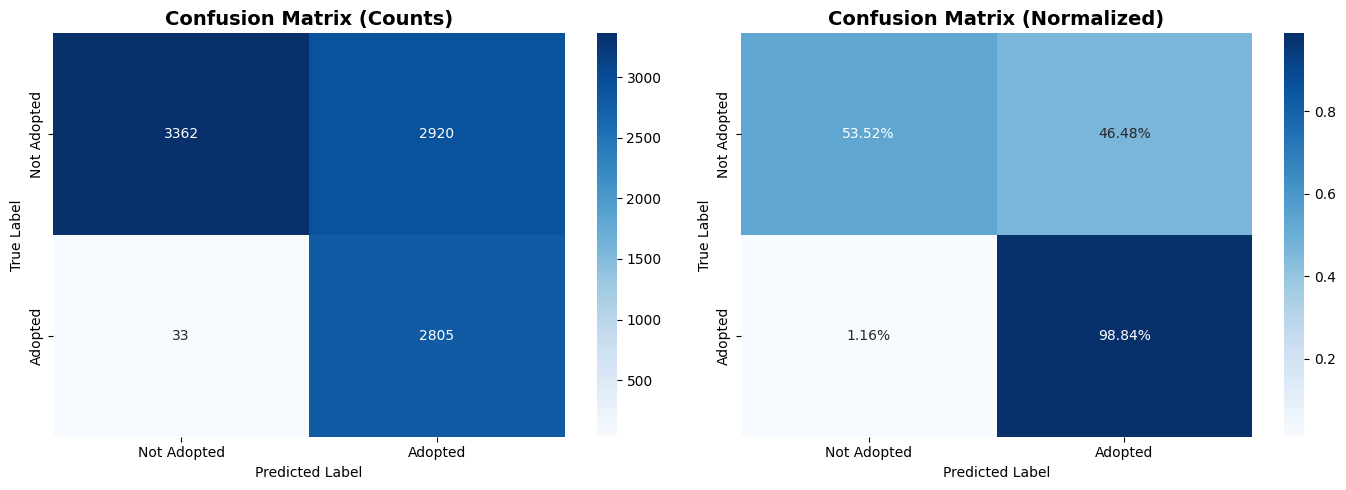

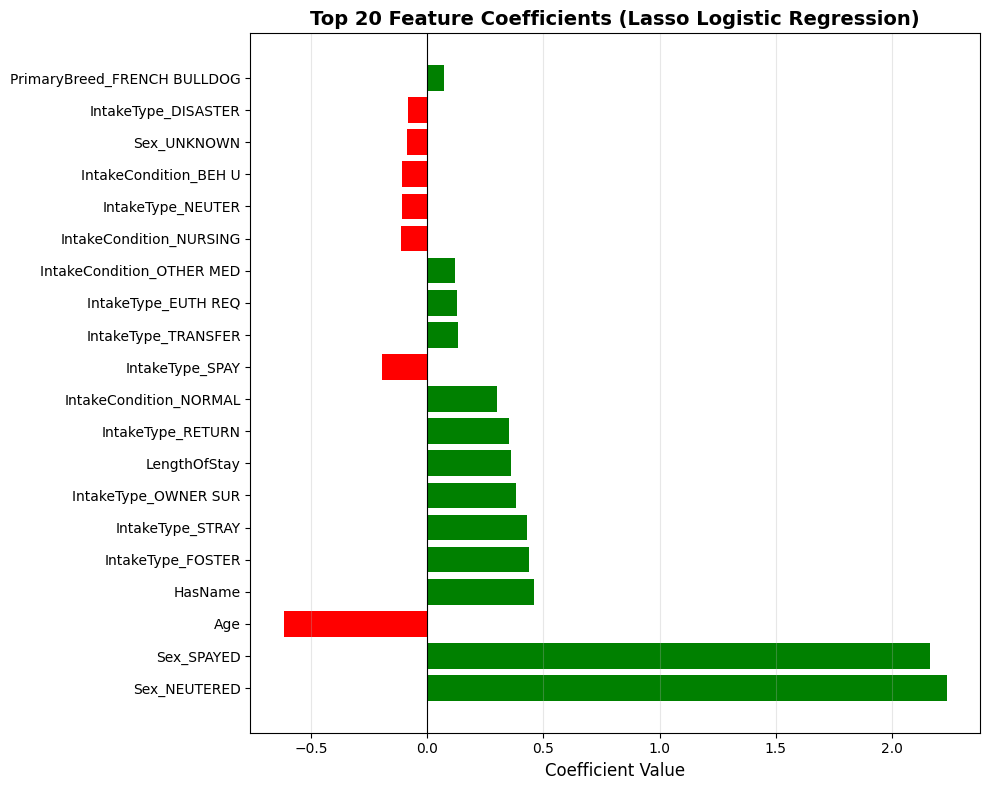

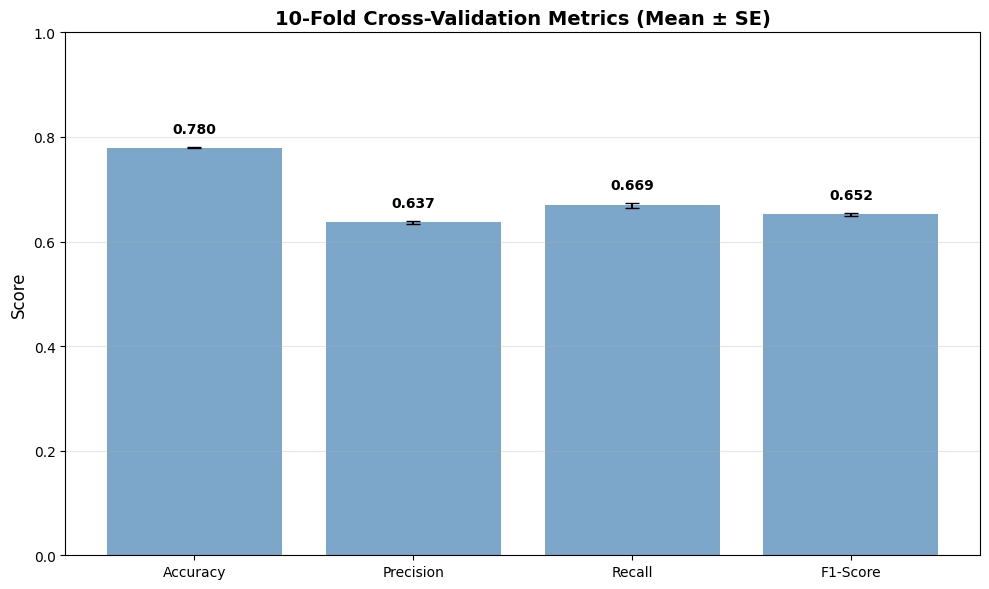

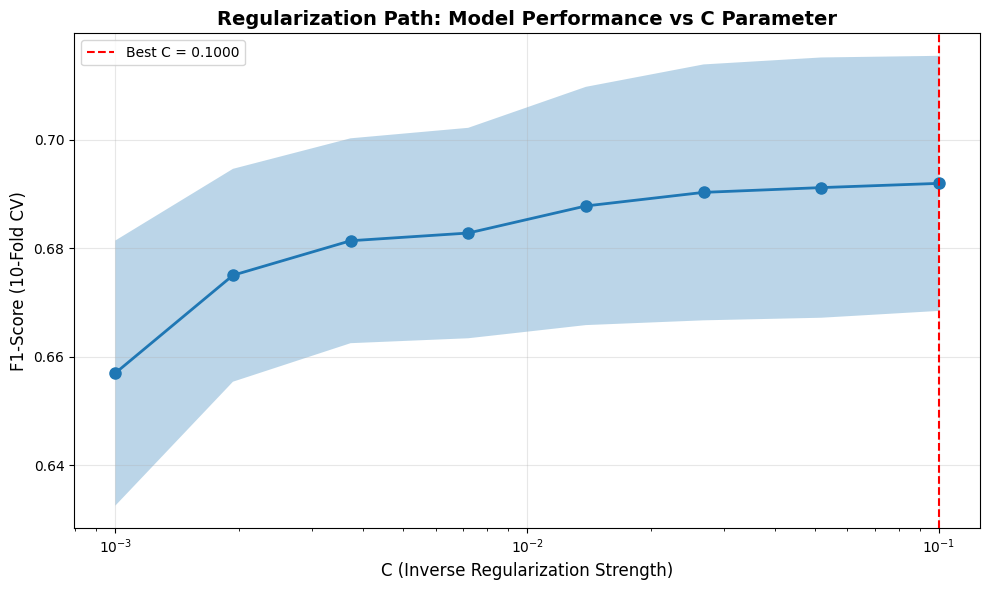

In [ ]:
# Some visualizations

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(yTs, yPredLasso)
cmNormalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Adopted', 'Adopted'],
            yticklabels=['Not Adopted', 'Adopted'])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold', fontsize=14)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cmNormalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['Not Adopted', 'Adopted'],
            yticklabels=['Not Adopted', 'Adopted'])
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('logistic_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
topFeatures = selectedFeatures.head(20)
colors = ['green' if x > 0 else 'red' for x in topFeatures['coefficient']]
plt.barh(range(len(topFeatures)), topFeatures['coefficient'], color=colors)
plt.yticks(range(len(topFeatures)), topFeatures['feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 20 Feature Coefficients (Lasso Logistic Regression)',
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-Validation Metrics
cvMetrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Mean': [accMean, precMean, recMean, f1Mean],
    'SE': [accSe, precSe, recSe, f1Se]
})

plt.figure(figsize=(10, 6))
xPos = np.arange(len(cvMetrics))
plt.bar(xPos, cvMetrics['Mean'], yerr=cvMetrics['SE'],
        capsize=5, alpha=0.7, color='steelblue')
plt.xticks(xPos, cvMetrics['Metric'])
plt.ylabel('Score', fontsize=12)
plt.title('10-Fold Cross-Validation Metrics (Mean ± SE)',
          fontweight='bold', fontsize=14)
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for i, (mean, se) in enumerate(zip(cvMetrics['Mean'], cvMetrics['SE'])):
    plt.text(i, mean + se + 0.02, f'{mean:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('logistic_cv_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Regularization Path
cvResults = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(10, 6))
plt.semilogx(cvResults['param_clf__C'], cvResults['mean_test_score'], 'o-',
             linewidth=2, markersize=8)
plt.fill_between(cvResults['param_clf__C'],
                 cvResults['mean_test_score'] - cvResults['std_test_score'],
                 cvResults['mean_test_score'] + cvResults['std_test_score'],
                 alpha=0.3)
plt.xlabel('C (Inverse Regularization Strength)', fontsize=12)
plt.ylabel('F1-Score (10-Fold CV)', fontsize=12)
plt.title('Regularization Path: Model Performance vs C Parameter',
          fontweight='bold', fontsize=14)
plt.axvline(x=grid.best_params_['clf__C'], color='red', linestyle='--',
            label=f"Best C = {grid.best_params_['clf__C']:.4f}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_regularization_path.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# SVM

# Prepare the data
X = dfDogs.drop(columns=[
    'Adopted', 'AnimalName', 'IntakeDate', 'OutcomeDate',
    'DOB', 'IntakeSubtype', 'IntakeReason', 'OutcomeType',
    'OutcomeSubtype', 'OutcomeCondition'
], errors='ignore')
y = dfDogs['Adopted']

print(f"\nDataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

# Train-test split
xTr, xTs, yTr, yTs = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTrain set: {len(xTr)}, Test set: {len(xTs)}")

# Build pipeline which helps us train with multiple types of kernels and evaluate them
def trainSvmPipeline(xTrain, yTrain, xTest, kernel='linear', C=1.0):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel=kernel, C=C, class_weight='balanced',
            probability=True, random_state=42
        ))
    ])

    startTime = time.time()
    pipeline.fit(xTrain, yTrain)
    trainTime = time.time() - startTime

    yPred = pipeline.predict(xTest)
    yProba = pipeline.predict_proba(xTest)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(yTs, yPred),
        'Precision': precision_score(yTs, yPred),
        'Recall': recall_score(yTs, yPred),
        'F1-Score': f1_score(yTs, yPred),
        'Training Time (s)': trainTime
    }

    return pipeline, metrics


Dataset shape: (30399, 74)
Number of features: 74

Train set: 21279, Test set: 9120


In [ ]:
# Linear kernel utilized
svmLinearPipeline, linearMetrics = trainSvmPipeline(
    xTr, yTr, xTs, kernel='linear', C=1.0
)
for k, v in linearMetrics.items():
    print(f"  {k}: {v:.4f}")

  Accuracy: 0.7294
  Precision: 0.5361
  Recall: 0.9295
  F1-Score: 0.6800
  Training Time (s): 477.0588


In [ ]:
# RBF kernel utilized
svmRbfPipeline, rbfMetrics = trainSvmPipeline(
    xTr, yTr, xTs, kernel='rbf', C=1.0
)
for k, v in rbfMetrics.items():
    print(f"  {k}: {v:.4f}")

  Accuracy: 0.7543
  Precision: 0.5632
  Recall: 0.9156
  F1-Score: 0.6974
  Training Time (s): 302.1709


In [ ]:
# Polynomial kernel utilized
svmPolyPipeline, polyMetrics = trainSvmPipeline(
    xTr, yTr, xTs, kernel='poly', C=1.0
)
for k, v in polyMetrics.items():
    print(f"  {k}: {v:.4f}")

  Accuracy: 0.7333
  Precision: 0.5406
  Recall: 0.9178
  F1-Score: 0.6804
  Training Time (s): 326.1526


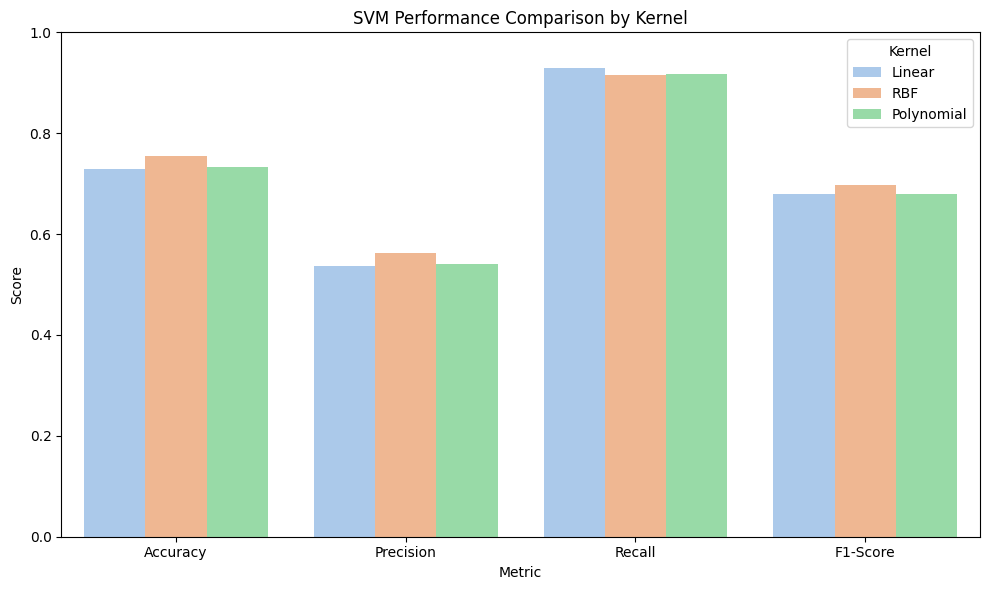

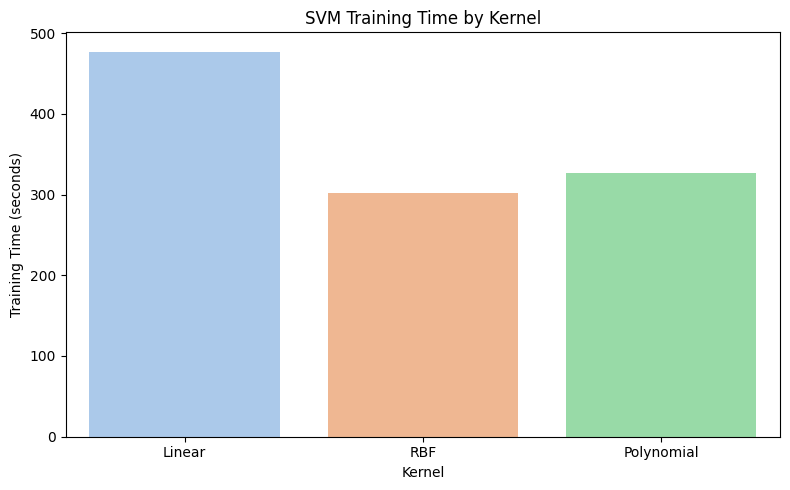

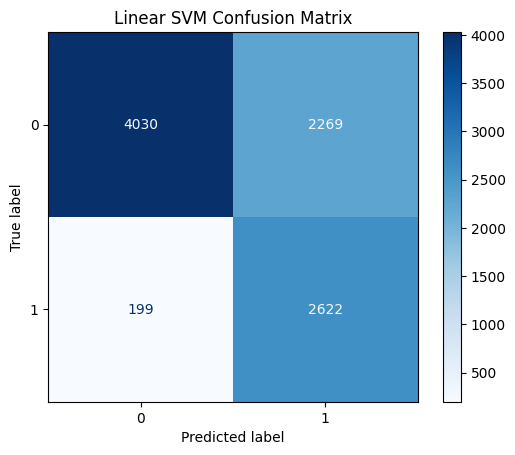

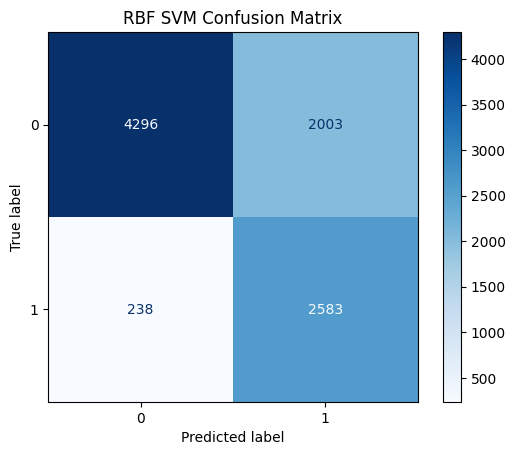

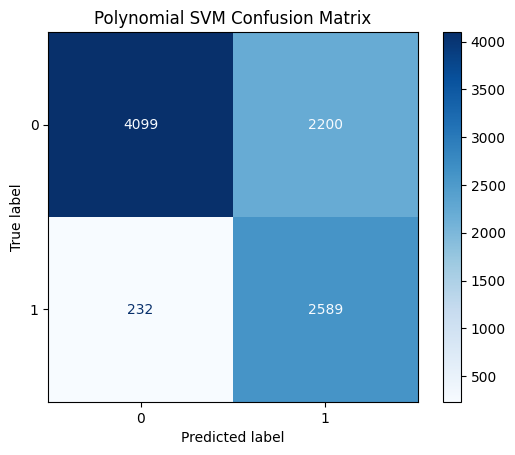

In [ ]:
# Comparing our models
# Compare metrics across kernels
metricsDf = pd.DataFrame({
    'Kernel': ['Linear', 'RBF', 'Polynomial'],
    'Accuracy': [
        linearMetrics['Accuracy'],
        rbfMetrics['Accuracy'],
        polyMetrics['Accuracy']
    ],
    'Precision': [
        linearMetrics['Precision'],
        rbfMetrics['Precision'],
        polyMetrics['Precision']
    ],
    'Recall': [
        linearMetrics['Recall'],
        rbfMetrics['Recall'],
        polyMetrics['Recall']
    ],
    'F1-Score': [
        linearMetrics['F1-Score'],
        rbfMetrics['F1-Score'],
        polyMetrics['F1-Score']
    ],
    'Training Time (s)': [
        linearMetrics['Training Time (s)'],
        rbfMetrics['Training Time (s)'],
        polyMetrics['Training Time (s)']
    ]
})

# Plot metrics comparison (excluding training time)
metricsPlot = metricsDf.melt(
    id_vars='Kernel',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Kernel', data=metricsPlot, palette='pastel')
plt.title("SVM Performance Comparison by Kernel")
plt.ylim(0, 1)
plt.legend(title='Kernel')
plt.tight_layout()
plt.show()

# Plot training time comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Kernel', y='Training Time (s)', data=metricsDf, palette='pastel')
plt.title("SVM Training Time by Kernel")
plt.ylabel('Training Time (seconds)')
plt.tight_layout()
plt.show()

# Confusion matrices for each kernel
for pipeline, kernelName in zip(
    [svmLinearPipeline, svmRbfPipeline, svmPolyPipeline],
    ['Linear', 'RBF', 'Polynomial']
):
    yPred = pipeline.predict(xTs)
    cm = confusion_matrix(yTs, yPred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"{kernelName} SVM Confusion Matrix")
    plt.show()

In [ ]:
# Neural Networks

# Load data
df = dfDogs.copy()

# Prepare features and target
X = df.drop(columns=[
    'Adopted', 'AnimalName', 'IntakeDate', 'OutcomeDate',
    'DOB', 'IntakeSubtype', 'IntakeReason', 'OutcomeType',
    'OutcomeSubtype', 'OutcomeCondition'
], errors='ignore')
y = df['Adopted']

print(f"\nDataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution:")
print(y.value_counts())
print(f"Adoption rate: {y.mean():.3f}")

# Train-test split
xTr, xTs, yTr, yTs = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTrain set: {len(xTr)}, Test set: {len(xTs)}")

# Scale features
scaler = StandardScaler()
xTrNp = scaler.fit_transform(xTr).astype(np.float32)
xTsNp = scaler.transform(xTs).astype(np.float32)
yTrNp = yTr.values.astype(np.float32)
yTsNp = yTs.values.astype(np.float32)

nx = xTrNp.shape[1]  # Number of input features
print(f"\nNumber of input features (nx): {nx}")



Dataset shape: (30399, 74)
Number of features: 74
Class distribution:
Adopted
0    20997
1     9402
Name: count, dtype: int64
Adoption rate: 0.309

Train set: 21279, Test set: 9120

Number of input features (nx): 74


In [ ]:
class SimpleNet(nn.Module):
    """
    Simple neural network with one hidden layer and Sigmoid activation.
    Architecture: Input → 64 neurons (Sigmoid) → 1 output (Sigmoid)
    """
    def __init__(self, inputSize, hiddenSize):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.activation = nn.Sigmoid()
        self.fc2 = nn.Linear(hiddenSize, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

class DeepNet(nn.Module):
    """
    Deep network with 3 hidden layers and ReLU activation.
    Architecture: Input → 128 (ReLU) → 64 (ReLU) → 32 (ReLU) → 1 (Sigmoid)
    """
    def __init__(self, inputSize, hiddenSizes):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hiddenSizes[0], hiddenSizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hiddenSizes[1], hiddenSizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hiddenSizes[2], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x
def trainModel(model, xTrain, yTrain, xTest, yTest, numEpochs=1000, lr=0.01, batchSize=256):
    """
    Train a PyTorch model and track training/testing metrics.
    Returns history dict with epochs, losses, and accuracies.
    """
    # Convert to PyTorch tensors
    xTrainTorch = torch.tensor(xTrain, dtype=torch.float32)
    yTrainTorch = torch.tensor(yTrain, dtype=torch.float32)[:, None]
    xTestTorch = torch.tensor(xTest, dtype=torch.float32)
    yTestTorch = torch.tensor(yTest, dtype=torch.float32)[:, None]

    # Create data loader for mini-batch training
    dataset = TensorDataset(xTrainTorch, yTrainTorch)
    dataLoader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track metrics
    trainLosses, trainAccs, testAccs, epochs = [], [], [], []

    for epoch in tqdm(range(numEpochs), desc="Training"):
        model.train()
        for inputs, labels in dataLoader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluation on train and test sets
        model.eval()
        with torch.no_grad():
            trainOutputs = model(xTrainTorch)
            trainPredicted = (trainOutputs > 0.5).float()
            trainAcc = (trainPredicted == yTrainTorch).float().mean().item()

            testOutputs = model(xTestTorch)
            testPredicted = (testOutputs > 0.5).float()
            testAcc = (testPredicted == yTestTorch).float().mean().item()

        trainLosses.append(loss.item())
        trainAccs.append(trainAcc)
        testAccs.append(testAcc)
        epochs.append(epoch)

    return {
        'epochs': np.array(epochs),
        'trainLosses': np.array(trainLosses),
        'trainAccs': np.array(trainAccs),
        'testAccs': np.array(testAccs)
    }

def evaluateModel(model, xTest, yTest):
    """
    Evaluate trained model on test set.
    Returns predictions and probabilities.
    """
    model.eval()
    xTestTorch = torch.tensor(xTest, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(xTestTorch)
        yPredProba = outputs.numpy().flatten()
        yPred = (yPredProba > 0.5).astype(int)
    return yPred, yPredProba

In [ ]:
# Model 1: Simple Network
model1 = SimpleNet(nx, 64)
history1 = trainModel(model1, xTrNp, yTrNp, xTsNp, yTsNp, numEpochs=1000, lr=0.01)
yPred1, yProba1 = evaluateModel(model1, xTsNp, yTsNp)


Training: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


In [ ]:
# Model 2: Deep Network with ReLU
model2 = DeepNet(nx, [128, 64, 32])
history2 = trainModel(model2, xTrNp, yTrNp, xTsNp, yTsNp, numEpochs=1000, lr=0.01)
yPred2, yProba2 = evaluateModel(model2, xTsNp, yTsNp)

Training: 100%|██████████| 1000/1000 [09:58<00:00,  1.67it/s]


In [ ]:
comparison = pd.DataFrame({
    'Model': ['SimpleNet (Sigmoid)', 'DeepNet (ReLU)'],
    'Architecture': ['64 hidden', '128-64-32'],
    'Accuracy': [
        accuracy_score(yTsNp, yPred1),
        accuracy_score(yTsNp, yPred2)
    ],
    'Precision': [
        precision_score(yTsNp, yPred1),
        precision_score(yTsNp, yPred2)
    ],
    'Recall': [
        recall_score(yTsNp, yPred1),
        recall_score(yTsNp, yPred2)
    ],
    'F1-Score': [
        f1_score(yTsNp, yPred1),
        f1_score(yTsNp, yPred2)
    ]
})


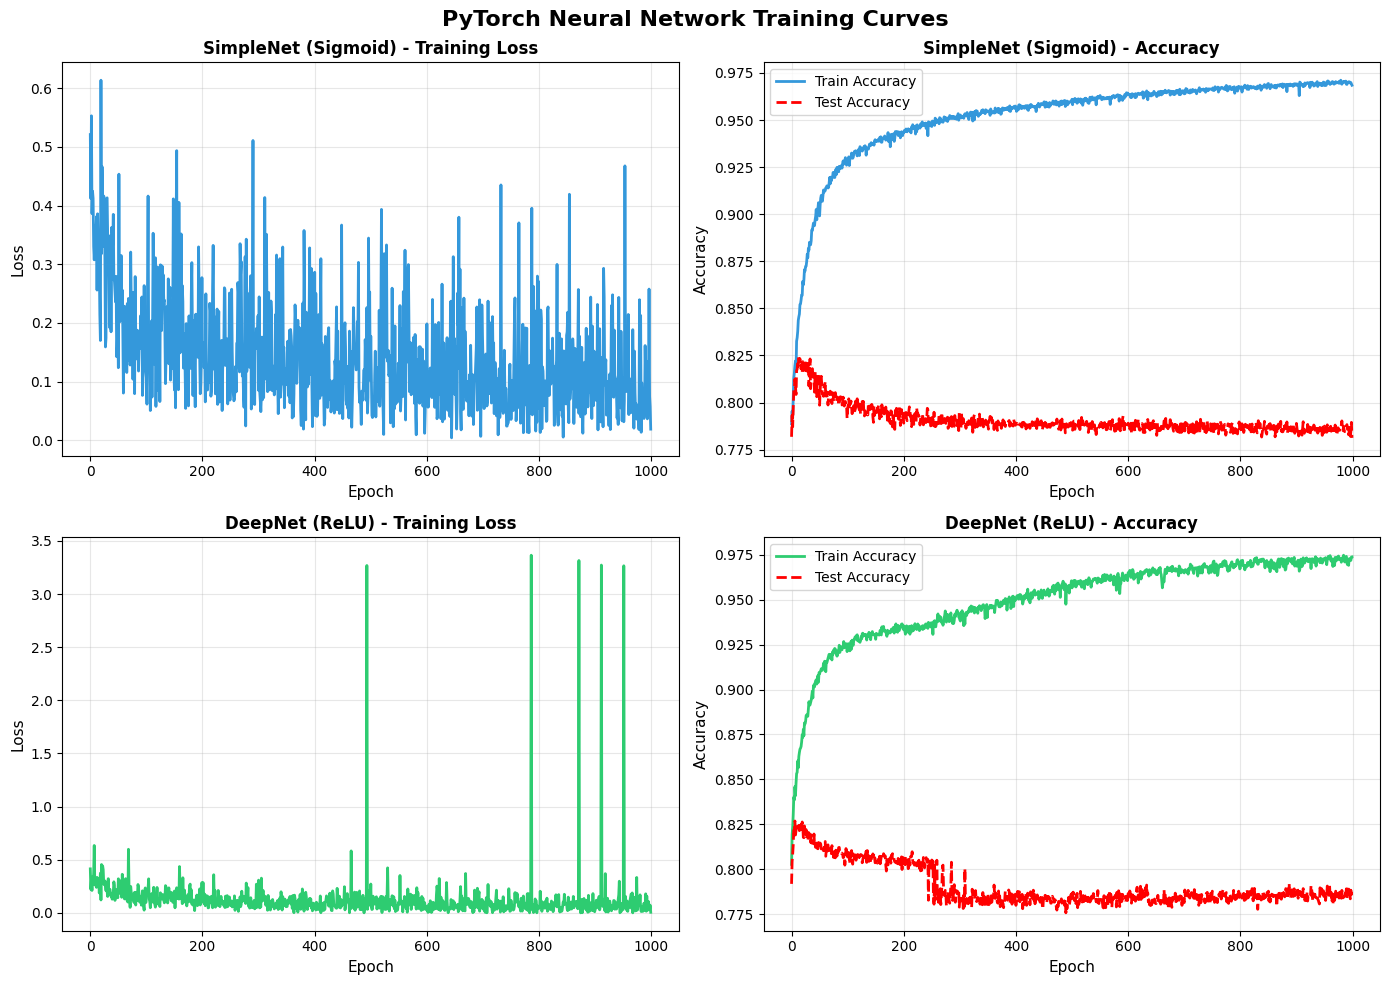

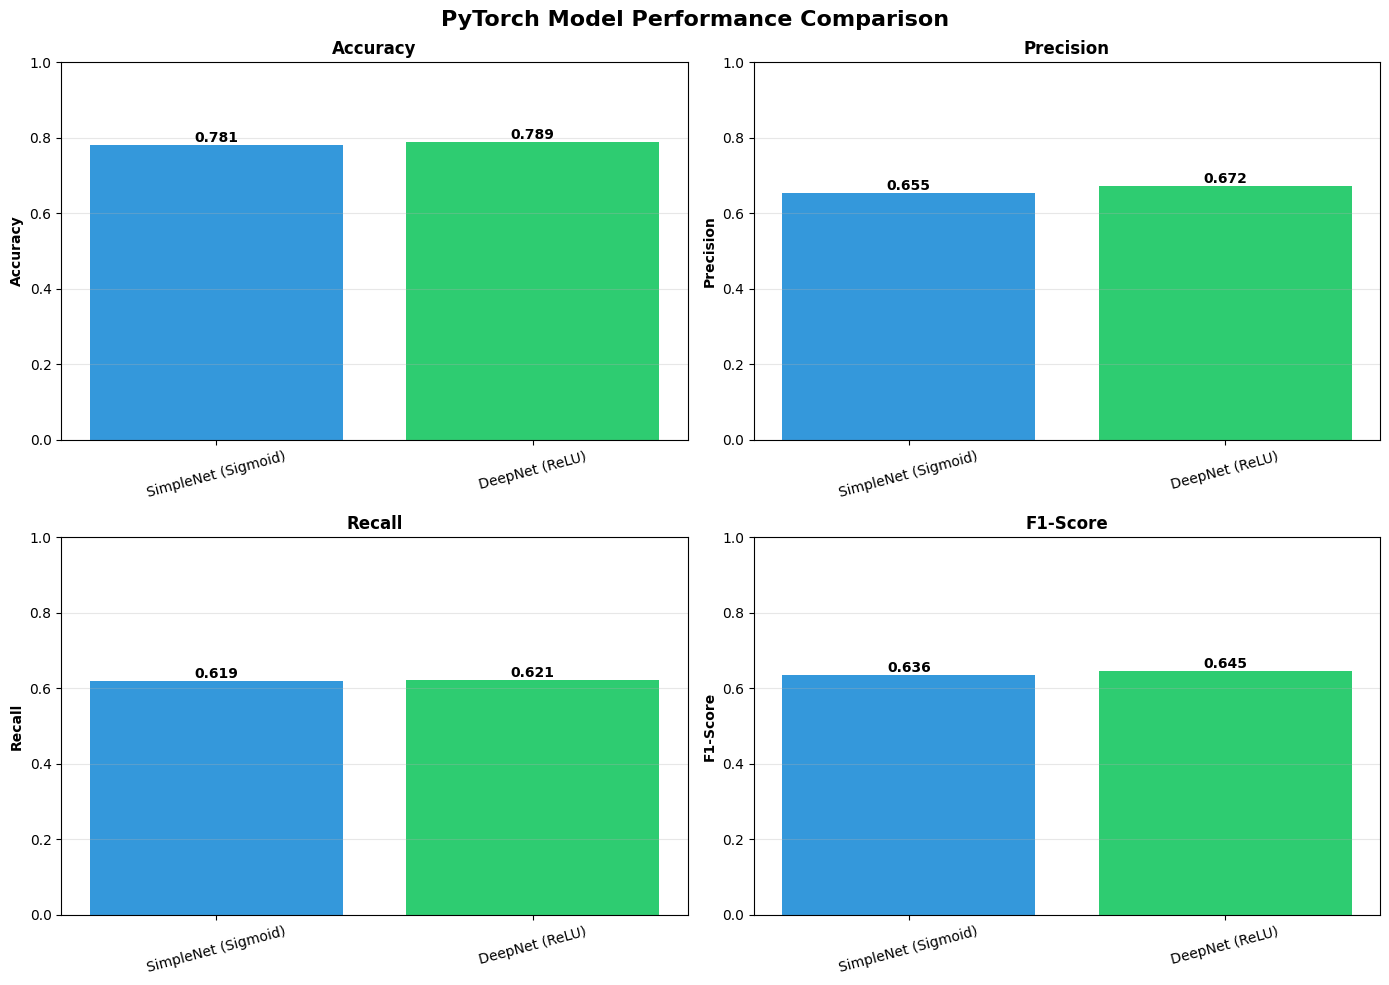

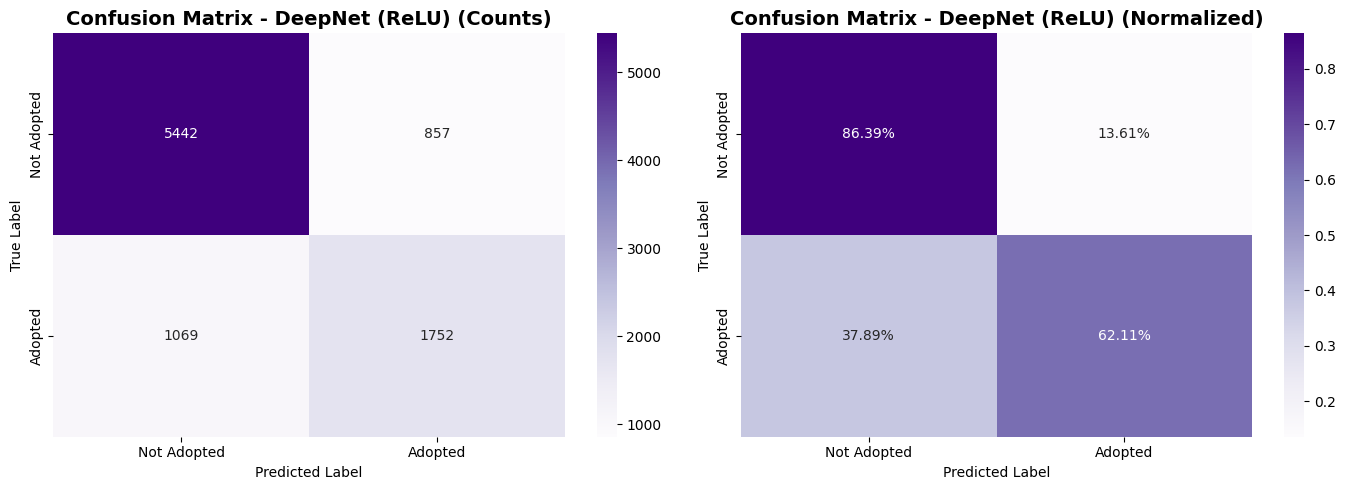

In [ ]:
# Some visualizations
# Training Curves (Loss and Accuracy)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PyTorch Neural Network Training Curves', fontsize=16, fontweight='bold')

modelsData = [
    (history1, 'SimpleNet (Sigmoid)', '#3498db'),
    (history2, 'DeepNet (ReLU)', '#2ecc71')
]

for idx, (history, title, color) in enumerate(modelsData):
    # Loss curve
    axes[idx, 0].plot(history['epochs'], history['trainLosses'],
                     linewidth=2, color=color)
    axes[idx, 0].set_xlabel('Epoch', fontsize=11)
    axes[idx, 0].set_ylabel('Loss', fontsize=11)
    axes[idx, 0].set_title(f'{title} - Training Loss', fontweight='bold')
    axes[idx, 0].grid(alpha=0.3)

    # Accuracy curves
    axes[idx, 1].plot(history['epochs'], history['trainAccs'],
                     linewidth=2, color=color, label='Train Accuracy')
    axes[idx, 1].plot(history['epochs'], history['testAccs'],
                     linewidth=2, color='red', linestyle='--', label='Test Accuracy')
    axes[idx, 1].set_xlabel('Epoch', fontsize=11)
    axes[idx, 1].set_ylabel('Accuracy', fontsize=11)
    axes[idx, 1].set_title(f'{title} - Accuracy', fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pytorch_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Comparison Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PyTorch Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    bars = ax.bar(comparison['Model'], comparison[metric], color=colors)
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(metric, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=15)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('pytorch_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix (Best Model)
bestIdx = comparison['F1-Score'].idxmax()
bestModelName = comparison.loc[bestIdx, 'Model']
bestPred = [yPred1, yPred2][bestIdx]

cm = confusion_matrix(yTsNp, bestPred)
cmNormalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['Not Adopted', 'Adopted'],
            yticklabels=['Not Adopted', 'Adopted'])
axes[0].set_title(f'Confusion Matrix - {bestModelName} (Counts)',
                  fontweight='bold', fontsize=14)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cmNormalized, annot=True, fmt='.2%', cmap='Purples', ax=axes[1],
            xticklabels=['Not Adopted', 'Adopted'],
            yticklabels=['Not Adopted', 'Adopted'])
axes[1].set_title(f'Confusion Matrix - {bestModelName} (Normalized)',
                  fontweight='bold', fontsize=14)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('pytorch_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
bestF1 = comparison.loc[bestIdx, 'F1-Score']

print(f"\nBest Model: {bestModelName}")
print(f"  • Test F1-Score: {bestF1:.4f}")

print("\nKey Findings:")
print("  • PyTorch allows full control over architecture and training")
print("  • ReLU activation generally outperforms Sigmoid for deep networks")
print("  • Adam optimizer successfully minimized loss")
print("  • Deep networks can capture complex patterns in the data")

print("\nGenerated visualizations:")
print("  1. pytorch_training_curves.png")
print("  2. pytorch_model_comparison.png")
print("  3. pytorch_confusion_matrix.png")

print("\n" + "="*80)
print("ALL MODELS COMPLETE!")
print("="*80)
print("\nModels trained:")
print("  1. Logistic Regression with Lasso (L1 Regularization)")
print("  2. Support Vector Machines (Linear, RBF, Polynomial kernels)")
print("  3. Neural Networks (SimpleNet, DeepNet)")



Best Model: DeepNet (ReLU)
  • Test F1-Score: 0.6453

Key Findings:
  • PyTorch allows full control over architecture and training
  • ReLU activation generally outperforms Sigmoid for deep networks
  • Adam optimizer successfully minimized loss
  • Deep networks can capture complex patterns in the data

Generated visualizations:
  1. pytorch_training_curves.png
  2. pytorch_model_comparison.png
  3. pytorch_confusion_matrix.png

ALL MODELS COMPLETE!

Models trained:
  1. Logistic Regression with Lasso (L1 Regularization)
  2. Support Vector Machines (Linear, RBF, Polynomial kernels)
  3. Neural Networks (SimpleNet, DeepNet)
